##### Packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.activations import gelu
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import re
import emoji

## Data Processing

In [2]:
data = pd.read_csv("C:/Users/vebky/FIE458/termpaper/Cleaned_Data.csv")
data.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,0,acs crypto,crims switch de-fi police trace crypto crimes ...,1,"[120015, 121920, 383174, 114220, 832007, 92474...","[153, 274, 260, 124, 62, 0, 62, 208, 260, 243,..."
1,1,acs crypto,welcome aircentralstation join aircentralstati...,1,"[66713, 41929, 324349, 41929, 243317, 1018295,...","[208, 86, 244, 153, 151, 124, 86, 0, 292, 260,..."
2,2,adaf,this zesty faucet from @_bitcoiner making twee...,1,"[109068, 689629, 1460276, 1476091, 113081, 317...","[243, 42, 260, 62, 0, 231, 86, 62, 243, 57, 0,..."
3,3,adaf,@bondwolfie . all doctors are fatphobic world ...,1,"[0, 883822, 420573, 826513, 1404114, 1048130, ...","[107, 160, 151, 218, 277, 208, 151, 244, 273, ..."
4,4,adaf,@umezawa_ honestly idk. might make sense check...,1,"[1179260, 410817, 1327918, 883822, 706844, 280...","[107, 173, 124, 86, 231, 292, 208, 292, 174, 0..."


##### Loading and Inspecting

In [3]:
# Sample a subset of the data, 50000 rows, which is 50% scam=1 and 50% scam=0
df = data.groupby('Scam').apply(lambda x: x.sample(25000, random_state=1)).reset_index(drop=True)
df.head()

,Unnamed: 0,Project,Text,Scam,Text_Encoded_Word,Text_Encoded_Character
0,327558,solana,sol price: $170.68 change 1h: +0.08864937% ma...,0,"[320229, 878608, 1148255, 118178, 653755, 1106...","[0, 62, 151, 244, 0, 266, 274, 260, 153, 86, 2..."
1,201917,elrond,@lpzhns @wesleybkress @_maiar @vz1904 @blackbe...,0,"[597088, 435012, 629607, 1302504, 1094131, 320...","[107, 244, 266, 231, 42, 218, 62, 0, 107, 208,..."
2,350262,tezos,"""crépus"" celebration the uniqueness black hair...",0,"[34924, 0, 34924, 1321284, 3780, 492643, 13000...","[225, 153, 274, 0, 266, 173, 62, 225, 0, 153, ..."
3,217940,ethereum classic,# (etc) unexpectedly classic tokens have poten...,0,"[845896, 614806, 1265595, 625586, 1094293, 150...","[285, 0, 175, 86, 243, 153, 105, 0, 173, 218, ..."
4,246376,holo,"was watching ""calli's christmas catastrophe"" a...",0,"[337827, 206703, 34924, 505250, 548834, 112863...","[208, 292, 62, 0, 208, 292, 243, 153, 42, 260,..."


In [4]:
# number of unique entries in "Scam" column and the count of each
df['Scam'].value_counts()

0    25000
1    25000
Name: Scam, dtype: int64

In [5]:
text = df['Text'].values

##### Formatting

In [6]:
# font to lowercase
text = [x.lower() for x in text]

# removing URLs from vocabulary
text = [re.sub(r'http\S+', '{URL}', x) for x in text]

# removing @mentions from vocabulary
text = [re.sub(r'@\S+', '', x) for x in text]

# filter out numbers
text = [re.sub(r'[0-9]+', '', x) for x in text]

# converting emojis to text
text = [emoji.demojize(x) for x in text]

# inspecting text after preprocessing
text[:5]

[' sol price: $. change h: +.% market cap: $,,,. ranking: # #sol lets go, big welcome  meow! #dopecats # {URL}  unique  based ecosystem nfts that changes peoples lives and gives our community the power shape the future blockchain!check out!',
 '     it’s nice see somebody speak up. instead just agreeing everything great. being gets your rekt.      more rollouts without that better than the rest the also ran dexes and for person that says you like talk things out calmly you sure are very aggressive saying don’t follow and saying somebody arrogant great read and good advice over here. #maiardex # #egld',
 '"crépus" celebration the uniqueness black hair. :woman_medium-dark_skin_tone_curly_hair::person_medium-dark_skin_tone_curly_hair::man_medium-dark_skin_tone_curly_hair: / photo collection available # via  {URL} #cleannft #nftphotographer #nftphotography #photo {URL} genesis blood moon ruination generative art with the help geometry nodes  xtz {URL} #cleannft #xtz #nft #rarible # #hen #o

In [7]:
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(text)

In [8]:
# see words in vocabulary
vocabulary = vectorizer.vocabulary_
vocabulary.items()

dict_items([('sol', 775), ('price', 659), ('change', 144), ('market', 512), ('cap', 134), ('lets', 467), ('go', 342), ('big', 89), ('welcome', 945), ('url', 898), ('unique', 891), ('based', 73), ('ecosystem', 245), ('nfts', 574), ('that', 836), ('and', 35), ('our', 605), ('community', 167), ('the', 837), ('power', 652), ('future', 320), ('blockchain', 104), ('check', 148), ('out', 606), ('it', 436), ('nice', 575), ('see', 738), ('up', 895), ('instead', 421), ('just', 441), ('everything', 271), ('great', 353), ('being', 83), ('gets', 332), ('your', 991), ('more', 549), ('without', 965), ('better', 87), ('than', 833), ('also', 26), ('for', 303), ('person', 628), ('says', 729), ('you', 990), ('like', 470), ('talk', 822), ('things', 846), ('sure', 814), ('are', 47), ('very', 918), ('saying', 728), ('don', 230), ('follow', 301), ('read', 686), ('good', 349), ('over', 607), ('here', 385), ('egld', 246), ('black', 100), ('collection', 162), ('available', 58), ('via', 920), ('moon', 548), ('ar

##### Training and Validation Sets

In [9]:
y = df['Scam'].values

In [10]:
# creating randomly selected balanced training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [11]:
# dimensions of training and validation sets
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 1000)
(10000, 1000)
(40000,)
(10000,)


In [12]:
# Convert the sparse matrices to dense arrays
X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

# Reshape the input data to have an additional dimension (channels)
X_train_reshaped = np.expand_dims(X_train_dense, axis=-1)
X_val_reshaped = np.expand_dims(X_val_dense, axis=-1)

In [13]:
# Callback to log variation of loss within each epoch
class BatchLossCallback(Callback):
    def __init__(self):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

## CNN Model

##### Model Architecture

In [24]:
# Functional API
# Input layer
inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

# Convolutional layer
conv1 = layers.Conv1D(128, 5, activation=gelu)(inputLayer)
drop1 = layers.Dropout(0.01)(conv1)

# MaxPooling layer
max_pool = layers.MaxPooling1D()(drop1)

# Dense Layer
flatten = layers.Flatten()(max_pool)
dense = layers.Dense(128, activation=gelu)(flatten)
dense2 = layers.Dense(32, activation=gelu)(dense)

# Output
output = layers.Dense(1, activation="sigmoid")(dense2)

# Create the model
model = Model(inputs=inputLayer, outputs=output)

In [25]:
# Optimiser
optimizer = Adam(learning_rate=0.001)

# Callbacks
batch_loss_callback = BatchLossCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min', restore_best_weights=True)

# Create a list of callbacks
callbacks_list = [early_stopping, batch_loss_callback]

In [26]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##### Performance and Metrics

History

In [27]:
# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, validation_data=(X_val_reshaped, y_val), batch_size=40, callbacks=callbacks_list)

Epoch 1/10
1000/1000 [==============================] - 161s 161ms/step - loss: 0.3788 - accuracy: 0.8060 - val_loss: 0.3420 - val_accuracy: 0.8279
Epoch 2/10
1000/1000 [==============================] - 152s 152ms/step - loss: 0.2937 - accuracy: 0.8550 - val_loss: 0.3339 - val_accuracy: 0.8329
Epoch 3/10
1000/1000 [==============================] - 150s 150ms/step - loss: 0.2181 - accuracy: 0.8992 - val_loss: 0.3614 - val_accuracy: 0.8348
Epoch 3: early stopping


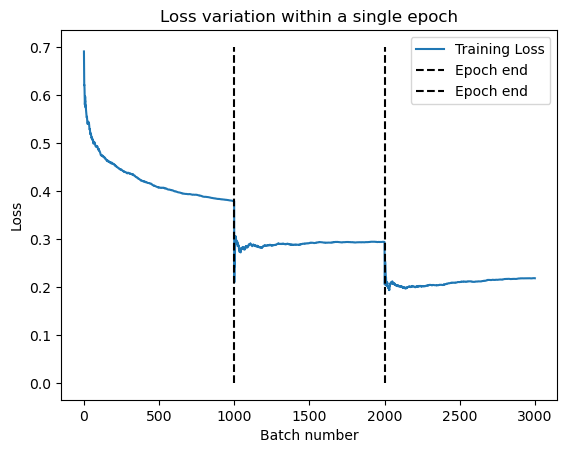

In [33]:
# Plot the batch-wise loss variation within the first epoch
plt.plot(np.arange(len(batch_loss_callback.batch_losses)), batch_loss_callback.batch_losses, label='Training Loss')
plt.vlines(1000, 0, 0.7, colors='k', linestyles='dashed', label='Epoch end')
plt.vlines(2000, 0, 0.7, colors='k', linestyles='dashed', label='Epoch end')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Loss variation within a single epoch')
plt.legend()
plt.show()

Validation

In [29]:
# Evaluate the model against Balanced Validation set
loss, accuracy = model.evaluate(X_val_reshaped, y_val)
print(f"Validation loss: {loss}, accuracy: {accuracy}")

313/313 [==============================] - 7s 23ms/step - loss: 0.3339 - accuracy: 0.8329
Validation loss: 0.3338654339313507, accuracy: 0.8328999876976013


Confusion Matrix

In [30]:
# Convert the sparse input data to dense format
X_val_dense = X_val.todense()

# Get the model's predictions on the dense validation set
y_pred = model.predict(X_val_dense)

313/313 [==============================] - 7s 23ms/step


In [31]:
y_pred_classes = np.round(y_pred).astype(int)  # For binary classification

[[3989 1011]
 [ 660 4340]]


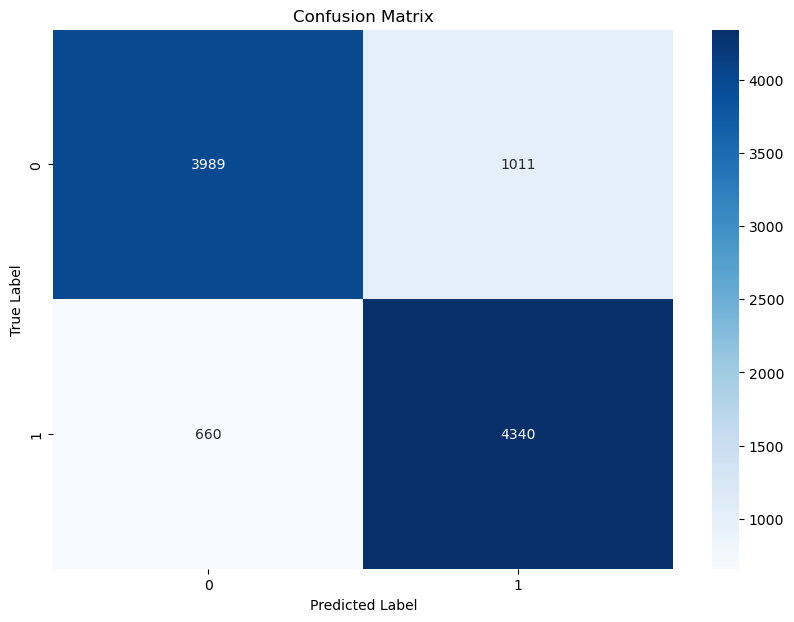

In [32]:
# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred_classes)
print(cm)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## LOG

### BOWCNN1: Sequential Convolutional Layers, Unbalanced Data


Validation loss: 0.4347321093082428, accuracy: 0.8156089186668396

Layers for the model

    model = tf.keras.Sequential([

    layers.Conv1D(64, 5, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),

    layers.MaxPooling1D(pool_size=4),

    layers.Conv1D(32, 5, activation='relu'),

    layers.GlobalMaxPooling1D(),

    layers.Dense(16, activation='relu'),

    layers.Dense(1, activation='sigmoid')

    ])

Compile the model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### BOWCNN2: Functional Convolutional Layers, Balanced Data

Validation loss: 0.2834297716617584, accuracy: 0.8761333227157593

Input layer

    inputLayer = layers.Input(shape=(X_train_reshaped.shape[1], 1))

Convolutional layer

    conv1 = layers.Conv1D(128, 5, activation=gelu)(inputLayer)

    drop1 = layers.Dropout(0.01)(conv1)

MaxPooling layer

    max_pool = layers.MaxPooling1D()(drop1)

Dense Layer

    flatten = layers.Flatten()(max_pool)

    dense = layers.Dense(128, activation=gelu)(flatten)
    
    dense2 = layers.Dense(32, activation=gelu)(dense)

Output
    output = layers.Dense(1, activation="sigmoid")(dense2)

Create the model

    model = Model(inputs=inputLayer, outputs=output)

Compile the model

    optimizer = Adam(learning_rate=0.001)

    early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, mode='min', restore_best_weights=True)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])